# Predicting House Sale Prices

We'll work with housing data for the city of Ames, Iowa, United States from 2006 to 2010. You can read more about why the data was collected [here](https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627)

Let's start by setting up a pipeline of functions that will let us quickly iterate on different models.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import KFold

%matplotlib inline

pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('AmesHousing.tsv', sep = '\t')
data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


Let's create 3 simple functions to use our raw data and use Linear Regression to predict the sale price of the houses with a train and a test dataset

In [3]:
def transform_features(df):
    return df

def select_features(df):
    return df[["Gr Liv Area", "SalePrice"]]

def train_and_test(df):
    train = df.iloc[:1460]
    test = df.iloc[1460:]
    
    num_train = train.select_dtypes(include=[int,float])
    num_test = test.select_dtypes(include=[int,float])

    all_but_price = num_train.columns[df.columns != 'SalePrice']
    
    lr = LinearRegression()
    lr.fit(train[all_but_price],train['SalePrice'])
    prediction = lr.predict(test[all_but_price])
    rmse = mean_squared_error(prediction,test['SalePrice'])**(1/2)
    return rmse

In [4]:
test1 = transform_features(data)
test1 = select_features(test1)
train_and_test(test1)

57088.25161263909

### Feature Engineering

Now let's start to improve our functions, first we need to clean our dataset


    
In general, the goal of this function is to: 

Handle missing values:

- remove features that we don't want to use in the model, just based on the number of missing values or data leakage

    - All columns:
        - Drop any with 5% or more missing values for now.
    - Text columns:
        - Drop any with 1 or more missing values for now.
    - Numerical columns:
        - For columns with missing values, fill in with the most common value in that column

Handle Sale columns
    
- remove any columns that leak information about the sale (e.g. like the year the sale happened)

Have new features

- create new features by combining other features

In [5]:
def transform_features(df):
    #Drop any columns that have more than 5% of null values
    more_5 = df[df.isnull().sum()[df.isnull().sum() > (0.05*df.shape[0])].index].columns
    df = df.drop(columns = more_5)
    
    #Fill the columns that have less than 5% of null values with the most recurrent value of the column
    less_5 = df[df.isnull().sum()[df.isnull().sum() < (0.05*df.shape[0])].index].columns
    for col in less_5:
        df[col] = df[col].fillna(df[col].mode()[0])
        
    #Drop the object columns that have 1 or more null values
    object_columns = df.select_dtypes(include=[object]).columns
    object_null = df[object_columns][df[object_columns].isnull().sum()[df[object_columns].isnull().sum() > 0].index].columns
    df = df.drop(columns = object_null)
    
    #Create a new column out of two and drop those two
    df ["years_until_remod"] = df ["Year Remod/Add"] - df["Year Built"]
    df ['years_before_sale'] = df['Yr Sold'] - df["Year Built"]
    df  = df.drop(columns = ["Year Remod/Add","Year Built"])
    
    #Drop all columns with the word "Sale" or "Sold" inside the column name
    df["Price"] = df["SalePrice"]
    sale_cols = [col for col in df.columns if ('Sale' in col) or ('Sold' in col)]
    df = df.drop(columns = sale_cols) 
    
    #Let's drop two columns that are irrelevant to our analysis
    df = df.drop(columns = ["PID", "Order"])
    
    return df

In [6]:
train_clean = transform_features(data)

Let's check if our new columns do not have some odd values :

In [7]:
train_clean[train_clean['years_before_sale'] < 0]

,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,years_until_remod,years_before_sale,Price
2180,20,RL,39290,Pave,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,Hip,CompShg,CemntBd,CmentBd,Stone,1224.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,4010.0,Unf,0.0,1085.0,5095.0,GasA,Ex,Y,SBrkr,5095,0,0,5095,1.0,1.0,2,1,2,1,Ex,15,Typ,2,3.0,1154.0,Y,546,484,0,0,0,0,17000,1,-1,183850


In [8]:
train_clean[train_clean["years_until_remod"] < 0]

,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,years_until_remod,years_before_sale,Price
850,20,RL,10739,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,68.0,Gd,TA,PConc,Gd,TA,No,GLQ,1259.0,Unf,0.0,172.0,1431.0,GasA,Ex,Y,SBrkr,1444,0,0,1444,1.0,0.0,2,0,3,1,Gd,6,Typ,0,2.0,577.0,Y,144,40,0,0,0,0,0,-1,7,203000


Let's remove those 2 rows by including this directly in our function

In [9]:
def transform_features(df):
    #Drop any columns that have more than 5% of null values
    more_5 = df[df.isnull().sum()[df.isnull().sum() > (0.05*df.shape[0])].index].columns
    df = df.drop(columns = more_5)
    
    #Fill the columns that have less than 5% of null values with the most recurrent value of the column
    less_5 = df[df.isnull().sum()[df.isnull().sum() < (0.05*df.shape[0])].index].columns
    for col in less_5:
        df[col] = df[col].fillna(df[col].mode()[0])
        
    #Drop the object columns that have 1 or more null values
    object_columns = df.select_dtypes(include=[object]).columns
    object_null = df[object_columns][df[object_columns].isnull().sum()[df[object_columns].isnull().sum() > 0].index].columns
    df = df.drop(columns = object_null)
    
    #Create a new column out of two and drop those two
    df ["years_until_remod"] = df ["Year Remod/Add"] - df["Year Built"]
    df ['years_before_sale'] = df['Yr Sold'] - df["Year Built"]
    df  = df.drop(columns = ["Year Remod/Add","Year Built"])
    
    #Drop all columns with the word "Sale" or "Sold" inside the column name
    df["Price"] = df["SalePrice"]
    sale_cols = [col for col in df.columns if ('Sale' in col) or ('Sold' in col)]
    df = df.drop(columns = sale_cols) 
    
    #Let's drop two columns that are irrelevant to our analysis
    df = df.drop(columns = ["PID", "Order"])

    #Remove negative values for our 2 new columns
    df = df.drop([850,2180])
    
    return df

Let's try our functions and see if our result improved :

In [10]:
def select_features(df):
    return df[["Gr Liv Area","Price"]]

In [11]:
def train_and_test(df):
    train = df.iloc[:1460]
    test = df.iloc[1460:]
    
    num_train = train.select_dtypes(include=[int,float])
    num_test = test.select_dtypes(include=[int,float])

    all_but_price = num_train.columns[df.columns != 'Price']
    
    lr = LinearRegression()
    lr.fit(train[all_but_price],train['Price'])
    prediction = lr.predict(test[all_but_price])
    rmse = mean_squared_error(prediction,test['Price'])**(1/2)
    return rmse

In [12]:
train_clean = transform_features(data)
train_select = select_features(train_clean)
train_and_test(train_select)

56072.52569017749

Our result has improved but we still can improve it. After cleaning our data we need to select only the most relevant features for our analysis!

### Feature Selection

Let's generate a correlation heatmap matrix of the numerical features in the training data set.

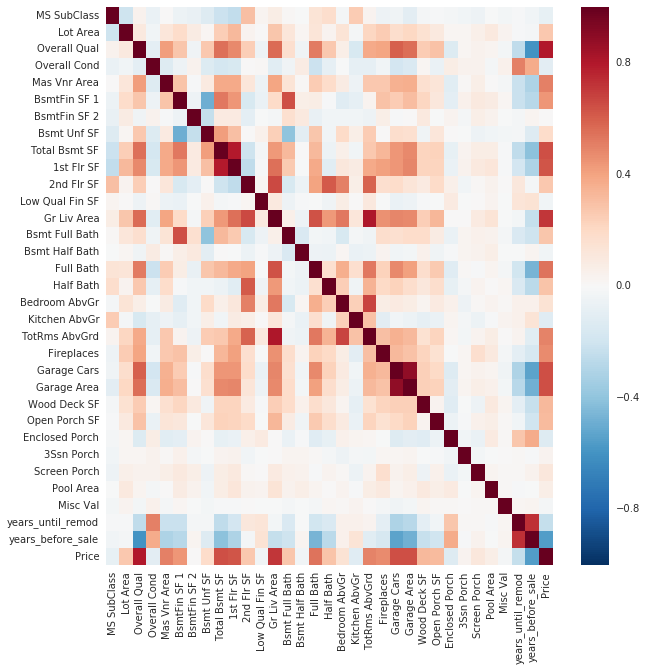

In [13]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(train_clean.select_dtypes(include=[int,float]).corr())

In [14]:
corr_train = train_clean.select_dtypes(include=[int,float]).corr()['Price'].abs().sort_values(ascending = False)
corr_train

Price                1.000000
Overall Qual         0.800279
Gr Liv Area          0.712893
Garage Cars          0.648071
Total Bsmt SF        0.641701
Garage Area          0.641184
1st Flr SF           0.632531
years_before_sale    0.559042
Full Bath            0.545641
Mas Vnr Area         0.505564
TotRms AbvGrd        0.497966
Fireplaces           0.475073
BsmtFin SF 1         0.437732
Wood Deck SF         0.327790
Open Porch SF        0.315141
Half Bath            0.285217
Bsmt Full Bath       0.275820
2nd Flr SF           0.269518
Lot Area             0.267122
years_until_remod    0.240133
Bsmt Unf SF          0.183447
Bedroom AbvGr        0.143939
Enclosed Porch       0.128756
Kitchen AbvGr        0.119795
Screen Porch         0.112187
Overall Cond         0.101652
MS SubClass          0.085020
Pool Area            0.068411
Low Qual Fin SF      0.037649
Bsmt Half Bath       0.035934
3Ssn Porch           0.032236
Misc Val             0.019295
BsmtFin SF 2         0.006050
Name: Pric

Let's only keep the columns that have a Pearson coefficient superior to 0.4 (arbitrary choosen)

In [15]:
corr_above_40 = corr_train[corr_train > 0.4].index
corr_above_40

Index(['Price', 'Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Total Bsmt SF',
       'Garage Area', '1st Flr SF', 'years_before_sale', 'Full Bath',
       'Mas Vnr Area', 'TotRms AbvGrd', 'Fireplaces', 'BsmtFin SF 1'],
      dtype='object')

**Let's use get_dummies!**

Which columns in the data frame should we convert to the categorical data type? All of the columns that can be categorized as nominal variables are candidates for being converted to categorical. 
However : 

- If a categorical column has hundreds of unique values (or categories), we should not use get_dummies

- If a column has a few unique values but more than 95% of the values in the column belong to a specific category : this would mean no variability in the data for the model to capture.


In [16]:
#Turn the "object" column into numerical one thanks to the get_dummies
object_columns = train_clean.select_dtypes(include=[object]).columns

In [17]:
for col in object_columns:
    x = data[col].value_counts()
    print("Column name is:",col,"and it value is:",x)
    print()

Column name is: MS Zoning and it value is: RL         2273
RM          462
FV          139
RH           27
C (all)      25
I (all)       2
A (agr)       2
Name: MS Zoning, dtype: int64

Column name is: Street and it value is: Pave    2918
Grvl      12
Name: Street, dtype: int64

Column name is: Lot Shape and it value is: Reg    1859
IR1     979
IR2      76
IR3      16
Name: Lot Shape, dtype: int64

Column name is: Land Contour and it value is: Lvl    2633
HLS     120
Bnk     117
Low      60
Name: Land Contour, dtype: int64

Column name is: Utilities and it value is: AllPub    2927
NoSewr       2
NoSeWa       1
Name: Utilities, dtype: int64

Column name is: Lot Config and it value is: Inside     2140
Corner      511
CulDSac     180
FR2          85
FR3          14
Name: Lot Config, dtype: int64

Column name is: Land Slope and it value is: Gtl    2789
Mod     125
Sev      16
Name: Land Slope, dtype: int64

Column name is: Neighborhood and it value is: NAmes      443
CollgCr    267
OldTown

We can see that a few columns have more than 95% of their rows filled with one value, which is the case for : 

- Street , Utilities, Land Slope, Condition 2, Roof Matl, Heating,

Some other column have two many values (let's say 10 is the maximum), which is the case for:

- Neighborhood, Exterior 1st, Exterior 2nd

Let's improve our transform_features function with those new elements:

In [18]:
def select_features(df,corr_value,nr_of_values):
    #We start by selecting only the columns with the highest correlation for the numerical features
    correlations = df.select_dtypes(include=[int,float]).corr()['Price'].abs().sort_values(ascending = False)
    corr_under_value = correlations[correlations < corr_value].index
    df = df.drop(columns = corr_under_value)
    
    clean_object_columns = []
    useless_columns = []
    
    #Select the object columns
    object_columns = df.select_dtypes(include=[object]).columns
    
    #Select only the object column without too many values or with no variability
    for col in object_columns:
        x = df[col].value_counts()
        if (len(x) < nr_of_values) & ((x[0]/sum(x)) < 0.95):
            clean_object_columns.append(col)
        else:
            useless_columns.append(col)
    
    df = df.drop(columns = useless_columns)
            
    #Use the get_dummies function to create new columns
    dummy_cols = pd.DataFrame()

    for col in df[clean_object_columns].columns:
        col_dummies = pd.get_dummies(df[col])
        df = pd.concat([df,col_dummies], axis = 1)
        #drop the old columns
        df = df.drop(columns = col)

    return df

In [19]:
def train_and_test(df):
    train = df.iloc[:1460]
    test = df.iloc[1460:]

    all_but_price = df.columns[df.columns != 'Price']
    
    lr = LinearRegression()
    lr.fit(train[all_but_price],train['Price'])
    prediction = lr.predict(test[all_but_price])
    rmse = mean_squared_error(prediction,test['Price'])**(1/2)
    return rmse

In [20]:
train_clean = transform_features(data)
train_select = select_features(train_clean,0.4,10)
train_and_test(train_select)

34080.00841125413

We made a huge improvement by selecting the right features! Finally let's improve our Train_and_Test function!

### Update train_and_test

Now that we have our final DataFrame, let's update our last function by implementing different cross validation. Let's add a parameter named k that controls the type of cross validation that occurs.

In [21]:
def train_and_test(df, k=0):
    
    lr = LinearRegression()
    all_but_price = df.columns[df.columns != 'Price']

    if k == 0:
        train = df.iloc[:1460]
        test = df.iloc[1460:]

        lr.fit(train[all_but_price],train['Price'])
        prediction = lr.predict(test[all_but_price])
        rmse = mean_squared_error(prediction,test['Price'])**(1/2)
        return rmse
    
    if k == 1:
        df = df.sample(frac=1).reset_index(drop=True)
        fold_one = df.iloc[:1460]
        fold_two = df.iloc[1460:]

        lr.fit(fold_one[all_but_price],fold_one['Price'])
        prediction = lr.predict(fold_two[all_but_price])
        rmse_one = mean_squared_error(prediction,fold_two['Price'])**(1/2)
        
        lr = LinearRegression()
        lr.fit(fold_two[all_but_price],fold_two['Price'])
        prediction = lr.predict(fold_one[all_but_price])
        rmse_two = mean_squared_error(prediction,fold_one['Price'])**(1/2)
        
        rmse = np.mean([rmse_one,rmse_two])
        return rmse
    
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            
            lr.fit(train[all_but_price], train["Price"])
            prediction = lr.predict(test[all_but_price])
            rmse = mean_squared_error(test["Price"], prediction)**(1/2)
            rmse_values.append(rmse)
            
        avg_rmse = np.mean([rmse_values])
        return avg_rmse
    

In [22]:
train_and_test(train_select, k=0)

34080.00841125413

In [23]:
train_and_test(train_select, k=1)

30408.55935943065

In [24]:
train_and_test(train_select, k=10)

28543.07991182221

Our result is getting better! Our RMSE dropped down from 57088 to 28325 by working on:

- our Dataset by cleaning it in the first place
- our features by selecting and shaping the right features
- our train and test phase by using different cross validation techniques

Now let's try one last technique, a bit more complex:

Let's see if we can narrow down a bit more the number of columns using the PCA technique.

The main idea of principal component analysis (PCA) is to reduce the dimensionality of a data set consisting of many variables correlated with each other, either heavily or lightly, while retaining the variation present in the dataset, up to the maximum extent. The same is done by transforming the variables to a new set of variables, which are known as the principal components

In [25]:
df1 = train_select.pop('Price') # remove column Price and store it in df1
train_select['Price']= df1 #We move it to the end of the Dataframe
train_select.tail()

,Overall Qual,Mas Vnr Area,BsmtFin SF 1,Total Bsmt SF,1st Flr SF,Gr Liv Area,Full Bath,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,years_before_sale,A (agr),C (all),FV,I (all),RH,RL,RM,IR1,IR2,IR3,Reg,Bnk,HLS,Low,Lvl,Corner,CulDSac,FR2,FR3,Inside,Artery,Feedr,Norm,PosA,PosN,RRAe,RRAn,RRNe,RRNn,1Fam,2fmCon,Duplex,Twnhs,TwnhsE,1.5Fin,1.5Unf,1Story,2.5Fin,2.5Unf,2Story,SFoyer,SLvl,Flat,Gable,Gambrel,Hip,Mansard,Shed,BrkCmn,BrkFace,CBlock,None,Stone,Ex,Fa,Gd,TA,Ex,Fa,Gd,Po,TA,BrkTil,CBlock,PConc,Slab,Stone,Wood,Ex,Fa,Gd,Po,TA,Ex,Fa,Gd,Po,TA,Av,Gd,Mn,No,ALQ,BLQ,GLQ,LwQ,Rec,Unf,ALQ,BLQ,GLQ,LwQ,Rec,Unf,Ex,Fa,Gd,Po,TA,N,Y,FuseA,FuseF,FuseP,Mix,SBrkr,Ex,Fa,Gd,Po,TA,Maj1,Maj2,Min1,Min2,Mod,Sal,Sev,Typ,N,P,Y,Price
2925,6,0.0,819.0,1003.0,1003,1003,1,6,0,2.0,588.0,22,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,142500
2926,5,0.0,301.0,864.0,902,902,1,5,0,2.0,484.0,23,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,131000
2927,5,0.0,337.0,912.0,970,970,1,6,0,0.0,0.0,14,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,132000
2928,5,0.0,1071.0,1389.0,1389,1389,1,6,1,2.0,418.0,32,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,170000
2929,7,94.0,758.0,996.0,996,2000,2,9,1,3.0,650.0,13,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,188000


In [29]:
# Feature Extraction with PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# load data
array = train_select.values
X = array[:,0:134]
Y = array[:,134]

# Standardizing the features
X = StandardScaler().fit_transform(X)
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3','principal component 4','principal component 5'])

finalDf = pd.concat([principalDf, train_select[['Price']]], axis = 1)
finalDf

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,Price
0,-0.296931,-3.077694,3.997734,-0.131376,1.583852,215000.0
1,-3.893033,-2.711629,-1.156553,0.229077,-0.585012,105000.0
2,-0.395376,-3.476384,0.066541,-0.080446,-0.007177,172000.0
3,2.538922,-2.394812,2.684377,-0.732657,-1.127642,244000.0
4,0.702980,0.466678,-1.647025,-0.991203,0.581057,189900.0
5,1.862793,0.589625,-1.028427,-1.167249,-0.269469,195500.0
6,3.230556,1.738616,-2.055556,2.944947,0.462583,213500.0
7,2.856042,1.246594,-1.695456,2.211517,1.806209,191500.0
8,3.925771,1.120023,-1.612852,2.373532,1.064663,236500.0
9,0.180456,1.685819,-1.096964,-2.032134,-1.205553,189000.0


In [31]:
null_data = finalDf[finalDf.isnull().any(axis=1)]
null_data

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,Price
850,3.737098,0.899161,-1.038850,0.958621,0.300025,NaN
2180,1.544404,1.379282,-2.424164,4.669684,-0.616222,NaN
2928,NaN,NaN,NaN,NaN,NaN,170000.0
2929,NaN,NaN,NaN,NaN,NaN,188000.0


In [32]:
finalDf = finalDf.drop([850,2180,2928,2929])

In [33]:
train_and_test(finalDf)

64274.716244901945

Well the result we obtain is awfull, we might have done something wrong above, we will come back to it as soon as we will have study a bit more about Features Selection for Machine Learning!